In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Data Reading and Handling

In [3]:
df_eng = pd.read_csv('Eng.csv')
df_eng.columns = ['word']
df_eng['language'] = 'eng'

In [4]:
df_eng[df_eng['word'].isna()]

,word,language
19278,NaN,eng


- pandas csv_reader interpreted the word 'null' as NaN so I fix that

In [5]:
df_eng = df_eng.fillna('null') 

In [6]:
df_tr = pd.read_csv('Turkish.csv')
df_tr.columns = ['word']
df_tr['language'] = 'tr'

In [7]:
df_tr[df_tr['word'].str.contains(' ')]

,word,language
223,bes on,tr
357,v yaka,tr
533,el gun,tr
605,ak kan,tr
680,ak yem,tr
750,lop et,tr
919,on soz,tr
961,on kol,tr
994,oz isi,tr
1054,uc iki,tr


- There are some words that are not actually single words.
- I will create new rows by splitting them
- I will drop 'v' since it is a single letter with no meaning without 'yaka'
- I will also drop duplicates in the cases above since there are many'on'

In [8]:
singlized_words = np.unique(np.reshape(df_tr[df_tr['word'].str.contains(' ')]['word'].str.split(" ").values.tolist(), -1))
singlized_words = singlized_words[singlized_words != 'v']
print(singlized_words)

['ak' 'bes' 'el' 'et' 'gun' 'ic' 'iki' 'isi' 'kan' 'kol' 'lop' 'on' 'oz'
 'soz' 'uc' 'yaka' 'yem']


- Now drop rows with double words and add these words into the dataframe as rows

In [9]:
df_tr = df_tr[~df_tr['word'].str.contains(' ')]

In [10]:
df_tr[df_tr['word'].str.contains(' ')]

,word,language


- Done

In [11]:
df_tr = pd.concat([df_tr, pd.DataFrame({'word': singlized_words, 'language': 'tr'})]).reset_index(
    drop = True)
df_tr.tail(10)

,word,language
2231,isi,tr
2232,kan,tr
2233,kol,tr
2234,lop,tr
2235,on,tr
2236,oz,tr
2237,soz,tr
2238,uc,tr
2239,yaka,tr
2240,yem,tr


- OK they are added to the tail

- Finally I can merge both tr and eng words into single table

In [12]:
df = pd.concat([df_eng, df_tr]).reset_index(drop = True)

# 1. Language Classification

I will create features below that I think might and will distinguish english words and turkish words from each other, 'syntatically'
### Features:
- Length of word
- Number of vowels / number of consonants ratio
- Number of consecutive vowels islands: 
        - in 'aabbbbcee' there are 2 islands of consecutive vowels made of a's and e's
- Number of consecutive consonants islands: 
        - similar to above, in 'aabbbbcee', there is a single island of consecutive consonants
- Max of consecutive vowel islands: 
        - in case there's more than 1 islands, the size of the biggest island
- Max of consecutive consonant islands: 
        - in case there's more than 1 islands, the size of the biggest island
- Number of unique letters / length of word
- Most frequently occured letter and second most frequntly occured letter
- Most frequently occured vowel
- Most frequently occured consonant
- Does it contain w, x, q
- Number of consecutive vowel-consonant switches / length of word: 
        - for example, there are 4 switches from vowels to consonants in 'araba', normalized by 5, we obtain 0.8. This can be distinctive because by nature, this happens a lot especially in original Turkish words.
- Number of consecutive letter repetitions: 
        - in the word 'mükerrer' there is one repetition of consecutive letters
- Does it start/end with english common prefixes/suffixes such as -ing, -ed, etc...
- One-Hot Encoding of Letters with number of occurences as values
        - this is rather straightforward approach but this way model can tell us which words vary between Turkish and English.

- Helper Objects and Functions

In [13]:
# Vowels and Consonants
vowels = ['a', 'e', 'i', 'o', 'u']
consonants = ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

# Helper Function that counts consecutive Trues in Boolean Lists
def consecutive_features(lst):
    a = np.array([lst]).T
    pad = np.zeros(a.shape[1],dtype=bool)
    mask = np.vstack((pad, a, pad))

    mask_step = mask[1:] != mask[:-1]
    idx = np.flatnonzero(mask_step.T)
    #island_starts = idx[::2]  # Not needed currently
    island_lens = idx[1::2] - idx[::2]
    return island_lens

In [14]:
features = []
for word in df['word']:

    # length of word
    length = len(word)

    # ----------------------------------------------------------------------------

    # number of vowels / consonants ratio
    number_of_vowels = 0
    number_of_consonants = 0
    for letter in word:
        if letter in vowels:
            number_of_vowels +=1
        else:
            number_of_consonants +=1

    vowels_consonants_ratio = number_of_vowels / (number_of_consonants + number_of_vowels)


    # ----------------------------------------------------------------------------
    # number of consecutive vowels islands
    # number of consecutive consonants islands
    # max of consecutive vowel islands
    # max of consecutive consonant islands

    binary_vowels = []
    binary_consonants = []
    for letter in word:
        if letter in vowels:
            binary_vowels.append(True)
            binary_consonants.append(False)
        else:
            binary_vowels.append(False)
            binary_consonants.append(True)

    # Vowels:
    vowel_islands = consecutive_features(binary_vowels)
    ones_removed = vowel_islands[vowel_islands != 1]

    number_of_consecutive_vowel_islands = len(ones_removed)

    if len(ones_removed) == 0:
        max_of_consecutive_vowel_islands = 0
    else:
        max_of_consecutive_vowel_islands = max(ones_removed)

    # Consonants:
    consonant_islands = consecutive_features(binary_consonants)
    ones_removed = consonant_islands[consonant_islands != 1]

    number_of_consecutive_consonant_islands = len(ones_removed)

    if len(ones_removed) == 0:
        max_of_consecutive_consonant_islands = 0
    else:
        max_of_consecutive_consonant_islands = max(ones_removed)

    # ----------------------------------------------------------------------------
    # number of unique letters
    # number of unique letters / len of word ratio
    # most frequent letter
    unique_letters, counts = np.unique(list(word), return_counts=True)
    number_of_unique_letters = len(unique_letters)
    number_of_unique_letters_over_len_word = number_of_unique_letters / len(word)
    most_frequent_letter = unique_letters[np.argmax(counts)]

    # second most frequent letter
    if number_of_unique_letters > 1:
        counts = np.delete(counts, np.argmax(counts))
        unique_letters = np.delete(unique_letters, np.argmax(counts))
        second_most_frequent_letter = unique_letters[np.argmax(counts)]
    else:
        second_most_frequent_letter = 'None'

    # ----------------------------------------------------------------------------
    # most frequent vowel and consonant
    vowels_in_word = np.array(list(word))[np.in1d(np.array(list(word)), vowels)]
    consonants_in_word = np.array(list(word))[np.in1d(np.array(list(word)), consonants)]

    # most frequent vowel
    unique_letters, counts = np.unique(vowels_in_word, return_counts=True)
    if len(unique_letters) != 0:
        most_frequent_vowel = unique_letters[np.argmax(counts)]
    else:
        most_frequent_vowel = 'None'
        
    # most frequent consonant
    unique_letters, counts = np.unique(consonants_in_word, return_counts=True)
    if len(unique_letters) != 0:
        most_frequent_consonant = unique_letters[np.argmax(counts)]
    else:
        most_frequent_consonant = 'None'

    # ----------------------------------------------------------------------------

    # does it contain q, w, x
    contains_qwx_letters = ('q' in word) or ('w' in word) or ('x' in word)


    # ----------------------------------------------------------------------------

    # Number of vowel-to-consonant / consonant-to-vowel switches
    number_of_vowel_consonant_switches = 0
    for i in range(len(word) - 1):
        if ((word[i] in vowels) & (word[i+1] in consonants)) or (
            (word[i] in consonants) & (word[i+1] in vowels)):
            number_of_vowel_consonant_switches += 1
    number_of_vowel_consonant_switches = number_of_vowel_consonant_switches / length 
    # Normalizing according to word length


    # ----------------------------------------------------------------------------

    # Number of consecutive letter repetitions
    lst_consecutive_same_letters = []
    for i in range(len(word) - 1):
        if word[i] == word[i+1]:
            lst_consecutive_same_letters.append(True)
        else:
            lst_consecutive_same_letters.append(False)

    consecutive_features_list = consecutive_features(lst_consecutive_same_letters)
    number_of_letter_repetitions = len(consecutive_features_list)
    
    # ----------------------------------------------------------------------------
    
    # Prefixes
    prefixes = ['re', 'dis', 'over', 'un', 'mis', 'out', 'be', 'co', 'de', 'fore', 'inter', 'pre', 'sub', 'trans', 'under',
                'anti', 'auto', 'bi', 'co', 'counter', 'dis', 'ex', 'hyper', 'in', 'inter', 'kilo', 'mal', 'mega', 'mis',
                'mini', 'mono', 'neo', 'out', 'poly', 'psuedo', 're', 'semi', 'sub', 'super', 'sur', 'tele', 'tri', 'ultra',
                'under', 'vice', 'un', 'im', 'in', 'ir', 'il', 'non', 'dis']

    contains_eng_prefix = False
    for prefix in prefixes:
        if word[0:len(prefix)] == prefix:
            contains_eng_prefix = True
            break

    
    # Suffixes
    suffixes = ['ise', 'ate', 'fy', 'en', 'tion', 'sion', 'er', 'ment', 'ant', 'ent', 'age', 'al', 'ence', 'ance', 'ery', 'ry',
                'ism', 'ship', 'ity', 'ness', 'cy', 'al', 'ent', 'ive', 'ous', 'ful', 'less', 'able']
    contains_eng_suffix = False
    for suffix in suffixes:
        if word[-len(suffix):] == suffix:
            contains_eng_suffix = True
            break

    # ----------------------------------------------------------------------------

    features.append([length, vowels_consonants_ratio, number_of_consecutive_vowel_islands, 
                     number_of_consecutive_consonant_islands, max_of_consecutive_vowel_islands, 
                     max_of_consecutive_consonant_islands, number_of_unique_letters,
                     number_of_unique_letters_over_len_word, most_frequent_letter, second_most_frequent_letter,
                     most_frequent_vowel, most_frequent_consonant, contains_qwx_letters,
                     number_of_vowel_consonant_switches, number_of_letter_repetitions,
                     contains_eng_prefix, contains_eng_suffix])


In [15]:
df_features = pd.DataFrame(features, columns = ['length', 'vowels_consonants_ratio', 'number_of_consecutive_vowel_islands', 
                     'number_of_consecutive_consonant_islands', 'max_of_consecutive_vowel_islands', 
                     'max_of_consecutive_consonant_islands', 'number_of_unique_letters',
                     'number_of_unique_letters_over_len_word', 'most_frequent_letter', 'second_most_frequent_letter',
                     'most_frequent_vowel', 'most_frequent_consonant', 'contains_qwx_letters',
                     'number_of_vowel_consonant_switches', 'number_of_letter_repetitions',
                                               'contains_eng_prefix', 'contains_eng_suffix'])

In [16]:
df_features.head()

,length,vowels_consonants_ratio,number_of_consecutive_vowel_islands,number_of_consecutive_consonant_islands,max_of_consecutive_vowel_islands,max_of_consecutive_consonant_islands,number_of_unique_letters,number_of_unique_letters_over_len_word,most_frequent_letter,second_most_frequent_letter,most_frequent_vowel,most_frequent_consonant,contains_qwx_letters,number_of_vowel_consonant_switches,number_of_letter_repetitions,contains_eng_prefix,contains_eng_suffix
0,6,0.166667,0,2,0,3,6,1.000000,f,g,i,f,False,0.333333,0,False,False
1,6,0.333333,0,1,0,2,5,0.833333,l,f,e,l,False,0.666667,1,False,False
2,6,0.500000,1,1,2,2,6,1.000000,a,c,a,c,False,0.500000,0,False,True
3,6,0.500000,1,0,2,0,6,1.000000,a,d,a,d,False,0.666667,0,False,False
4,6,0.333333,0,1,0,2,5,0.833333,n,f,a,n,False,0.666667,0,False,False


In [17]:
df_features_dummy = pd.get_dummies(df_features)

- One-Hot Encoding of Letters with corresponding number of occurence/frequency in the word

In [18]:
%%time
# one-hot encode for letters with counts
df_one_hot_letters = pd.DataFrame()
for word in df['word']:
    df_one_hot_letters = pd.concat([df_one_hot_letters, pd.Series(
        list(word)).str.get_dummies().sum()], axis = 1, sort = True)
    
df_one_hot_letters = df_one_hot_letters.T.fillna(0).astype(int).reset_index(drop = True)
df_one_hot_letters['word'] = df['word'].values
df_one_hot_letters['language'] = df['language'].values

CPU times: user 1min 38s, sys: 9.16 s, total: 1min 47s
Wall time: 1min 47s


In [64]:
df_one_hot_letters.sample(10)

,a,b,c,d,e,f,g,h,i,j,...,s,t,u,v,w,x,y,z,word,language
16857,0,0,0,0,2,1,0,0,0,0,...,0,1,0,0,0,0,0,0,trefle,eng
2149,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,beira,eng
22259,0,0,0,0,2,0,0,0,1,0,...,1,0,0,0,0,0,0,0,esirme,tr
10433,0,0,0,0,1,0,0,0,1,0,...,0,2,1,0,0,0,0,0,urtite,eng
14425,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,drant,eng
16437,3,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,satara,eng
23668,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,nakit,tr
12168,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,gnar,eng
19888,0,0,0,0,1,0,0,1,2,0,...,1,1,0,0,0,0,0,0,histie,eng
10397,0,0,0,0,0,0,0,1,0,0,...,1,0,2,0,0,0,0,0,uprush,eng


- Merging manually created features with one-hot-letter features

In [20]:
df_final = df_features_dummy.merge(df_one_hot_letters, left_index = True, right_index = True)

- I want to see the results without onehotencoded letters, too

In [21]:
#df_features_dummy['word'] = df['word']
#df_features_dummy['language'] = df['language']
#df_final = df_features_dummy

In [22]:
df_final

,length,vowels_consonants_ratio,number_of_consecutive_vowel_islands,number_of_consecutive_consonant_islands,max_of_consecutive_vowel_islands,max_of_consecutive_consonant_islands,number_of_unique_letters,number_of_unique_letters_over_len_word,contains_qwx_letters,number_of_vowel_consonant_switches,...,s,t,u,v,w,x,y,z,word,language
0,6,0.166667,0,2,0,3,6,1.000000,False,0.333333,...,0,0,0,0,0,0,1,0,flying,eng
1,6,0.333333,0,1,0,2,5,0.833333,False,0.666667,...,0,1,0,0,0,0,0,0,fillet,eng
2,6,0.500000,1,1,2,2,6,1.000000,False,0.500000,...,0,0,0,0,0,0,0,0,fiance,eng
3,6,0.500000,1,0,2,0,6,1.000000,False,0.666667,...,0,0,0,0,0,0,0,0,failed,eng
4,6,0.333333,0,1,0,2,5,0.833333,False,0.666667,...,1,0,0,0,0,0,0,0,fanons,eng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23902,2,0.500000,0,0,0,0,2,1.000000,False,0.500000,...,0,0,0,0,0,0,0,1,oz,tr
23903,3,0.333333,0,0,0,0,3,1.000000,False,0.666667,...,1,0,0,0,0,0,0,1,soz,tr
23904,2,0.500000,0,0,0,0,2,1.000000,False,0.500000,...,0,0,1,0,0,0,0,0,uc,tr
23905,4,0.500000,0,0,0,0,3,0.750000,False,0.750000,...,0,0,0,0,0,0,1,0,yaka,tr


- Manual/Eye inspection shows that features are matched correctly with the words, meaning there is no index shift or anything

In [23]:
np.unique(df_final.drop(['word', 'language'], axis = 1).dtypes)

array([dtype('bool'), dtype('uint8'), dtype('int64'), dtype('float64')],
      dtype=object)

- Data types are also suitable for scikit-learn's ML algorithms

### Train/Development and Test Splits

- I will divide the data into two parts.
    - 1st part will be Train & Development set: 0.75 of the original data. Namely X and y
    - 2nd part will be Test set that I will not touch at all until final stage of the process, just like a Kaggle competition. 0.25 of the original data. Namely X_test and y_test
    
    
- Imbalanced data requires metrics such as recall, precision, Fscore. Since it is binary classification, I will simply replace 'tr' and 'eng' with 0 and 1 to make use of these metrics better according to my framework
- Since 'tr' is minority, I will replace 'tr' with 1 and 'eng' with 0

In [26]:
X = df_final.drop(['word', 'language'], axis = 1)
y = df_final['language'].replace('tr', 1).replace('eng', 0).astype(int)

In [27]:
from sklearn.model_selection import train_test_split
X, X_final_test, y, y_final_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

In [28]:
y.value_counts(normalize = True)

0    0.905577
1    0.094423
Name: language, dtype: float64

In [29]:
y_final_test.value_counts(normalize = True)

0    0.908315
1    0.091685
Name: language, dtype: float64

- OK target variable distribution is roughly the same for both Train/Dev set and Test sets

### Machine Learning

- We have an imbalanced data, 90% of which is English and rest being Turkish, so I will try SMOTE and SMOTEEN to OverSample the minority class, knowing it's a good practice
- Having experience, I know Random Forest, LGBM, XGboost and MLP are good classifiers. So I won't waste cycles over less successfull/outdated methods such as SVM, Logistic Regression, KNN, etc.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [107]:
y.dtypes

dtype('int64')

- I will use my 'ML Classification Framework for Imbalanced Data' that I had written for a previous project, which can be found in my github

In [129]:
# Classifiers
clf_rf = RandomForestClassifier(n_jobs = -1)
clf_xgb = XGBClassifier(n_jobs = -1, probability = True)
clf_lgbm = lgb.LGBMClassifier(n_jobs = -1,silent = True)
clf_mlp = MLPClassifier(max_iter = 500) # it did not converge for 200 iterations

- To prevent overfitting, X and y will be created again without Scaling and SMOTE otherwise Overfit and Data Leak will occur
- To make sure no overfitting happens but still be able to use Scaling and SMOTE, these two transformation will be applied only after Train/Test split in each of 5-fold CV

In [131]:
classifiers = [clf_rf, clf_xgb, clf_lgbm, clf_mlp]
clf_list=[]
for clf in classifiers:
    clf_list.append(clf.__class__.__name__)
    
my_metrics = ['Accuracy_dict','BalancedAccuracy_dict', 'Recall_dict', 
              'Precision_dict', 'Fscore_dict']
scaler = StandardScaler()

skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
Accuracy_dict = {}
BalancedAccuracy_dict = {}
Recall_dict = {}
Precision_dict = {}
Fscore_dict = {}
clf_list=[]
conf_rf = np.zeros([2,2])
conf_xgb = np.zeros([2,2])
conf_lgbm = np.zeros([2,2])
conf_mlp = np.zeros([2,2])
conf_eclf = np.zeros([2,2])

pred_dict = pd.DataFrame(columns = clf_list)

for clf in classifiers:
    clf_list.append(clf.__class__.__name__)

stacked_results = pd.DataFrame()
stacked_probabilities = pd.DataFrame()
final_ensembled_metrics = pd.Series(np.zeros([1,len(my_metrics)])[0])
final_probs = pd.DataFrame()
aggregated_y_test = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    # -----  Carrying out Scaling and OverSampling after Train Test split prevents overfitting/Data Leak
    # Scaling
    #scaler.fit(X_train)
    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)

    # PCA
    #pca = PCA(n_components = n_of_components)
    #pca.fit(X_train)
    #X_train = pca.transform(X_train)
    #X_test = pca.transform(X_test)

    # Sampling
    # SMOTE
    #sampler = SMOTE(sampling_strategy = 'minority') # Synthetic Minority Over Sampling Technique
    #X_train, y_train = sampler.fit_sample(X_train, y_train)
    
    # SMOTEENN
    sampler = SMOTEENN(random_state=42)
    X_train, y_train = sampler.fit_sample(X_train, y_train)

    a = pd.DataFrame()
    b = pd.DataFrame()
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = pd.Series(clf.predict(X_test))
        train_probabilities = pd.Series(clf.predict_proba(X_test)[:,1])
        Accuracy = metrics.accuracy_score(y_test, train_predictions)
        BalancedAccuracy = metrics.balanced_accuracy_score(y_test, train_predictions)
        Recall = metrics.recall_score(y_test, train_predictions)
        Precision = metrics.precision_score(y_test, train_predictions)
        Fscore = metrics.f1_score(y_test, train_predictions)

        if clf == clf_rf:
            conf_rf += metrics.confusion_matrix(y_test, train_predictions)
        if clf == clf_xgb:
            conf_xgb += metrics.confusion_matrix(y_test, train_predictions)
        if clf == clf_lgbm:
            conf_lgbm += metrics.confusion_matrix(y_test, train_predictions)
        if clf == clf_mlp:
            conf_mlp += metrics.confusion_matrix(y_test, train_predictions)


        for x in my_metrics:
            if name in eval(x):
                eval(x)[name] += eval(x.split("_")[0])
            else:
                eval(x)[name] = eval(x.split("_")[0])
        a = pd.concat([a, train_predictions], axis=1)
        b = pd.concat([b, train_probabilities], axis=1)
    
    probs = pd.DataFrame(b.mean(axis=1))
    
    final_probs = pd.concat([final_probs, b], axis = 0)
    aggregated_y_test = np.concatenate((aggregated_y_test, y_test.values))
    probs[probs[0] < 0.5] = 0
    probs[probs[0] >= 0.5] = 1
    ensembled_preds = probs
    conf_eclf += metrics.confusion_matrix(y_test, ensembled_preds)
    ensembled_metrics = []
    ensembled_metrics.append(metrics.accuracy_score(y_test, ensembled_preds))
    ensembled_metrics.append(metrics.balanced_accuracy_score(y_test, ensembled_preds))
    ensembled_metrics.append(metrics.recall_score(y_test, ensembled_preds))
    ensembled_metrics.append(metrics.precision_score(y_test, ensembled_preds))
    ensembled_metrics.append(metrics.f1_score(y_test, ensembled_preds))
    final_ensembled_metrics += pd.Series(ensembled_metrics)

    stacked_results = pd.concat([stacked_results,a], axis = 0)
stacked_results.columns = clf_list

final_probs['GT'] = aggregated_y_test
clf_list.append('GT')
final_probs.columns = clf_list
final_probs = final_probs.round(2)

metric_results = pd.DataFrame()
for x in my_metrics:
    metric_results = metric_results.append(pd.DataFrame(
        data = [list((eval(x).values()))] , columns = list((eval(x).keys()))))
metric_results.index = ["Accuracy", "Bal_Accuracy", "Recall", "Precision", "Fscore"]
metric_results['EnsembledClassifiers'] = list(final_ensembled_metrics)
metric_results = metric_results.T/5

### Evaluation Metrics

- The metrics I will inspect are: Accuracy, Balanced Accuracy, Recall, Precision and Fscore
- After Model Selection, I will:
    - Tune HyperParameters via GridSearch.
    - Inspect ROC/AUC curve to tune the model even further.
    - Tune probability threshold for predictions
    - Inspect Feature Importances

- Results of Base Models: StandardScaler and SMOTE

In [116]:
metric_results

,Accuracy,Bal_Accuracy,Recall,Precision,Fscore
RandomForestClassifier,0.907418,0.602862,0.227402,0.522454,0.316805
XGBClassifier,0.913107,0.625575,0.271104,0.586676,0.370551
LGBMClassifier,0.914501,0.620796,0.258713,0.611725,0.363044
MLPClassifier,0.876520,0.636849,0.341383,0.344596,0.342923
EnsembledClassifiers,0.908756,0.629517,0.285272,0.531658,0.370926


- Results of Base Models: NO SCALING and SMOTE

In [118]:
metric_results

,Accuracy,Bal_Accuracy,Recall,Precision,Fscore
RandomForestClassifier,0.892359,0.654069,0.360303,0.418354,0.386910
XGBClassifier,0.902621,0.659207,0.359124,0.480041,0.410602
LGBMClassifier,0.895650,0.672823,0.398120,0.442343,0.418719
MLPClassifier,0.890184,0.635671,0.321906,0.399190,0.355177
EnsembledClassifiers,0.904016,0.649666,0.336100,0.487262,0.397449


- Results of Base Models: NO SCALING and SMOTEENN

In [132]:
metric_results

,Accuracy,Bal_Accuracy,Recall,Precision,Fscore
RandomForestClassifier,0.820413,0.739727,0.640259,0.293393,0.402305
XGBClassifier,0.839208,0.742702,0.623731,0.320493,0.423153
LGBMClassifier,0.829782,0.753100,0.658568,0.310944,0.422197
MLPClassifier,0.836364,0.709643,0.553425,0.301506,0.389404
EnsembledClassifiers,0.844562,0.745652,0.623718,0.330236,0.431290


In [122]:
print(X.max().max())
print(X.min().min())

6.0
0.0


- Oddly, Scaling worsens the model performances, even for MLP
    - That can be explained by the fact that most of the features in the data is normalized already, min and max values of all table are shown above
    - And many being dummy variables(0 - 1)
- SMOTE combined with ENN: SMOTEEN improved the results of SMOTE so I will proceed with SMOTEEN.
- Ensembling provides the best score however such computationaly expensive methods are mostly appropriate for Kaggle only.
- I won't be using Scaling anymore since:
    - It only worsened the scores
    - I will use a Tree Based model, XGBoost, where scaling is irrelevant
- XGBoost seems to provide the best Fscore and I will continue with XGBoost, tuning its hyperparameters and probability threshold.

### Model Tuning - HyperParameter Search

In [133]:
X.shape

(17930, 119)

- To be able to use SMOTEEN in CV, I have to use PipeLine. Otherwise, applying SMOTEEN transformation before split will cause Data Leakage

In [139]:
from imblearn.pipeline import make_pipeline, Pipeline

smote_enn = sampler = SMOTEENN(random_state = 42)
clf = XGBClassifier(n_jobs = -1, probability = True)
pipeline = make_pipeline(smote_enn, clf_xgb)
#print(pipeline.get_params().keys()) # this is very important to get the keys to parameters in pipeline

# XGBoost
grid_xgb = {'xgbclassifier__min_child_weight': [1, 3, 5, 7, 10, 12, 15, 20, 25, 30, 40],
        'xgbclassifier__gamma': [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 3, 4, 5],
        'xgbclassifier__subsample': [0.3, 0.5, 0.7, 1.0],
        'xgbclassifier__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        'xgbclassifier__max_depth': [3, 5, 9, 15, 20, 25, 30]}

xgb_grid_search = RandomizedSearchCV(pipeline, grid_xgb, cv = 5, n_jobs = -1, verbose = 1, scoring = "f1", random_state = 0,
                                     n_iter = 20)
xgb_grid_search.fit(X, y)
print("Score: ",xgb_grid_search.best_score_)
print(xgb_grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:  4.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


Score:  0.43439222992155824
{'xgbclassifier__subsample': 1.0, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__max_depth': 15, 'xgbclassifier__gamma': 2, 'xgbclassifier__colsample_bytree': 0.5}


- By optimizing hyperparameters, it has been possible to increase the F1 score by 2.67 %.
- It's time to set these parameters

In [39]:
clf = XGBClassifier(n_jobs = -1, probability = True, subsample = 1.0, min_child_weight = 20,
                    max_depth = 15, gamma = 2, colsample_bytree = 0.5)

### Testing the Tuned Model

In [42]:
%%time
stacked_predictions = pd.Series(dtype = float)
stacked_probabilities = pd.Series(dtype = float)
stacked_gt = pd.Series(dtype = float)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # SMOTEENN
    sampler = SMOTEENN(random_state = 42)
    X_train, y_train = sampler.fit_sample(X_train, y_train)
    
    clf.fit(X_train, y_train)
    preds = pd.Series(clf.predict(X_test))
    probs = pd.Series(clf.predict_proba(X_test)[:,1])

    stacked_predictions = pd.concat([stacked_predictions, preds])
    stacked_probabilities = pd.concat([stacked_probabilities, probs])
    stacked_gt = pd.concat([stacked_gt, y_test])

CPU times: user 3min 31s, sys: 136 ms, total: 3min 31s
Wall time: 3min 31s


In [43]:
accuracy = metrics.accuracy_score(stacked_gt, stacked_predictions)
recall = metrics.recall_score(stacked_gt, stacked_predictions)
precision = metrics.precision_score(stacked_gt, stacked_predictions)
f1 = metrics.f1_score(stacked_gt, stacked_predictions)

In [44]:
pd.DataFrame([accuracy, recall, precision, f1], columns = ['XGBoostClassifier'], 
             index = ['Accuracy', 'Recall', 'Precision', 'F1_Score'])

,XGBoostClassifier
Accuracy,0.851757
Recall,0.603071
Precision,0.339541
F1_Score,0.434468


- As tested, tuned XGBoostClassifier model predicts with 0.434 F1_Score

### ROC/AUC

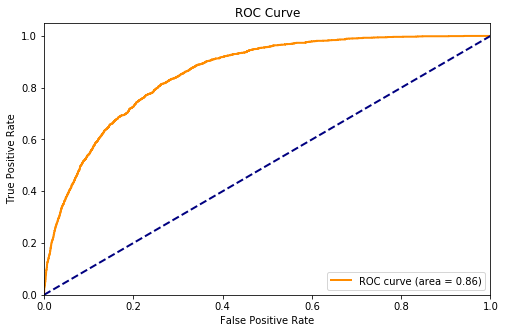

In [45]:
# ROC
fpr, tpr, threshold = metrics.roc_curve(stacked_gt, stacked_probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (8, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

- This figure shows that tradeoff between Recall and Precision are rather equal and to increase the TP in some amount, you need to give up on FP around the same amount. 
- That is because I resolved the issue of imbalance using a mix of Over and Under Sampling techniques, namely SMOTEEN.
- It is still possible to tune model furthermore by tuning according to the predicted probabilities

### Probability Threshold Tuning

In [46]:
lst_threshold = np.linspace(0, 1, 500)
lst_f1score = []
for threshold in lst_threshold:
    new_preds = (stacked_probabilities.values >= threshold) * 1
    lst_f1score.append(metrics.f1_score(stacked_gt, new_preds))

tuned_probability = lst_threshold[np.argmax(lst_f1score)]

Text(0.627254509018036, 0.4372023063424417, 'x')

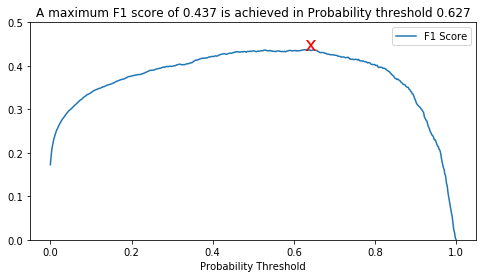

In [47]:
fig, ax = plt.subplots()
pd.DataFrame({'Probability Threshold': lst_threshold, 'F1 Score': lst_f1score}).set_index(
    'Probability Threshold').plot(ax = ax,
    title = "A maximum F1 score of " + str(round(max(lst_f1score), 3)) + 
                                  " is achieved in Probability threshold " + 
                                  str(round(lst_threshold[np.argmax(lst_f1score)], 3)), 
                                  figsize = (8, 4))

#ax.axvline(tuned_probability, color = 'red')
ax.set_ylim(0, 0.5)
ax.annotate('x', (tuned_probability, max(lst_f1score)), color = 'red', size = 20)

### Feature Importance

In [276]:
sampler = SMOTEENN(random_state = 42)
X_os, y_os = sampler.fit_sample(X, y)

clf = XGBClassifier(n_jobs = -1, probability = True, subsample = 1.0, min_child_weight = 20,
                    max_depth = 15, gamma = 2, colsample_bytree = 0.5)
clf.fit(X_os, y_os)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              probability=True, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method=None,
              validate_parameters=False, verbosity=None)

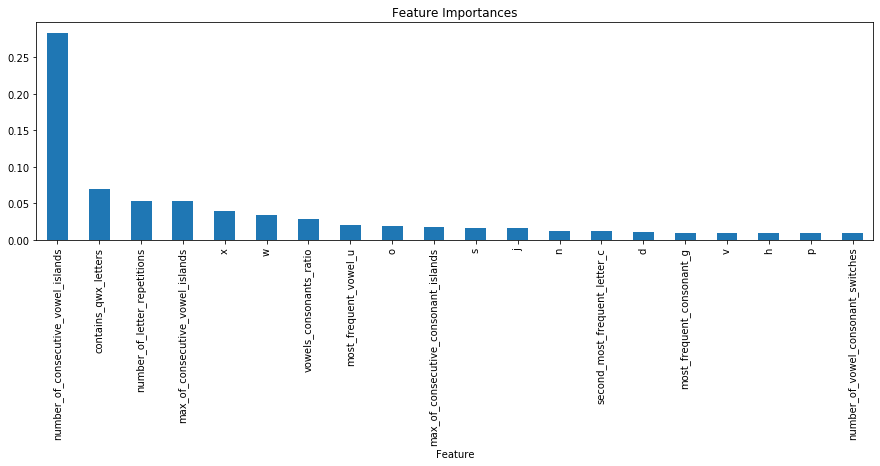

In [314]:
df_fi = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_}).sort_values(
    by = 'Importance', ascending = False)
df_fi.set_index('Feature').head(20).plot(kind = 'bar', rot = 90, figsize = (15, 4), 
                                         title = 'Feature Importances', legend = False)

- When feature importances for XGBoost Classifier model is inspected, it is observed that most important features are:
    - Number of Consecutive Vowel Islands
    - Whether the word contains English letters 'QWX'
    - Number of Letter Repetitions
    - Vowel Island with the maximum length in the word
    - Vowels / (Vowels + Consonants) ratio
    - Frequency and usage of some letters such as u, o, s, j, n, c, g,v
    - Number of Consonant/Vowel Switches
    
- Because:
    - In English there are a lot of words made of consecutive vowels whereas that's more rare in Turkish. Also it is possible to see words with 3 consecutive vowels in English. That's unlikely for Turkish.
    - QWX feature's importance is rather trivial since Turkish words do not contain those letters
    - It seems letter repetitions is much more common in English compared to Turkish
    - Letters such as 'o', 's', 'j' are more common in English than Turkish.
    - In Turkish, especially the words that remained in our language from the original Asian origins, neither two vowels nor consonants do not come together but they switch between consonant and vowel, as in the case of 'ana', 'baba'.
    
    
- I would expect to see English prefix and suffix features as important but they are not in top 20, oddly

In [279]:
pd.DataFrame({'number_of_letter_repetitions': X['number_of_letter_repetitions'].values, 
              'language': y.values}).groupby('language').mean()

,number_of_letter_repetitions
language,
0,0.147195
1,0.032487


In [280]:
pd.DataFrame({'vowels_consonants_ratio': X['vowels_consonants_ratio'].values, 
              'language': y.values}).groupby('language').mean()

,vowels_consonants_ratio
language,
0,0.390139
1,0.417366


In [281]:
pd.DataFrame({'o': X['o'].values, 'language': y.values}).groupby('language').mean()

,o
language,
0,0.358441
1,0.207324


In [282]:
pd.DataFrame({'s': X['s'].values, 'language': y.values}).groupby('language').mean()

,s
language,
0,0.349326
1,0.236267


In [284]:
pd.DataFrame({'j': X['j'].values, 'language': y.values}).groupby('language').mean()

,j
language,
0,0.050009
1,0.025989


### Predicting for Final Test Data

In [32]:
sampler = SMOTEENN(random_state = 42)
X_train, y_train = sampler.fit_sample(X, y)

clf = XGBClassifier(n_jobs = -1, probability = True, subsample = 1.0, min_child_weight = 20,
                    max_depth = 15, gamma = 2, colsample_bytree = 0.5)
clf.fit(X_train, y_train)
y_gt = y_final_test
y_predicted = clf.predict(X_final_test)
y_probs = clf.predict_proba(X_final_test)[:,1]

In [33]:
accuracy = metrics.accuracy_score(y_gt, y_predicted)
recall = metrics.recall_score(y_gt, y_predicted)
precision = metrics.precision_score(y_gt, y_predicted)
f1 = metrics.f1_score(y_gt, y_predicted)
pd.DataFrame([accuracy, recall, precision, f1], columns = ['XGBoostClassifier'], 
             index = ['Accuracy', 'Recall', 'Precision', 'F1_Score'])

,XGBoostClassifier
Accuracy,0.851765
Recall,0.616788
Precision,0.333333
F1_Score,0.432778


- Confusion Matrix

In [35]:
pd.DataFrame(metrics.confusion_matrix(y_gt, y_predicted, normalize = 'all')).round(3)

,0,1
0,0.795,0.113
1,0.035,0.057


- The F1 Score result is very similar to the one in model development phase, 0.43. Therefore the effort to prevent Overfitting paid off.

- Lastly, I will try the tuned probability to see whether it will improve the result

In [48]:
tuned_prob_preds = (y_probs >= tuned_probability) * 1

accuracy = metrics.accuracy_score(y_gt, tuned_prob_preds)
recall = metrics.recall_score(y_gt, tuned_prob_preds)
precision = metrics.precision_score(y_gt, tuned_prob_preds)
f1 = metrics.f1_score(y_gt, tuned_prob_preds)
df_final_results = pd.DataFrame([accuracy, recall, precision, f1], 
                                columns = ['XGBoostClassifier'], 
                                index = ['Accuracy', 'Recall', 'Precision', 'F1_Score'])
df_final_results

,XGBoostClassifier
Accuracy,0.877363
Recall,0.534672
Precision,0.380026
F1_Score,0.444276


- YAY! Tuned probability boosted the F1 Score by 2.6%, additional to increasing Accuracy, too.
- I am happy to see that this effort resulted in improvement

### Word Inspection of Classification Results

In [59]:
df_inspection = df.loc[X_final_test.index.values]
df_inspection['prediction'] = tuned_prob_preds
df_inspection['prediction'] = df_inspection['prediction'].astype(str).replace('0', 'eng').replace('1', 'tr')

In [62]:
df_inspection[df_inspection['language'] != df_inspection['prediction']].sample(30)

,word,language,prediction
7696,yuzluk,eng,tr
21354,kermis,eng,tr
1538,mezuza,eng,tr
23145,doseme,tr,eng
2576,begift,eng,tr
23325,surume,tr,eng
16903,tekya,eng,tr
9462,jole,eng,tr
16931,tamul,eng,tr
21107,karat,eng,tr


In [61]:
df_inspection[df_inspection['language'] != df_inspection['prediction']].sample(30)

,word,language,prediction
23555,istop,tr,eng
21192,kiley,eng,tr
5873,abada,eng,tr
23438,teamul,tr,eng
18080,impala,eng,tr
2236,batara,eng,tr
8299,ovant,eng,tr
22965,gocus,tr,eng
17741,ihlat,eng,tr
1588,mockup,eng,tr


- When misclassified words are inspected I realize many of these words are hard ones in terms of syntatical distinction, but also hard semantically, too. I do not know the meanings of most of them
- For example:
    - teamul and siirce words are classified as english. That makes sense because they contain "ea", "ii" in them, consecutive vowels, something more frequently seen in English words.
    - istop is classified as english, which is understandable.
    - nizams is classified as turkish, because in fact it is a turkish origined word! nizam!
    - some of the missclassified english words such as rebake, kari, resile, lidar, batara, abada fall into the rule of "number of consonant-vowel switches", which is seen a lot in turkish.
    - some of the words are labelled so odd that if I was asked to classify, I would do the same mistakes with the model. For example, jole, yuzluk, humus, lavas, tamul, karat sound Turkish to me, but in the label they are English.

### Conclusion and Future Research

- It is not easy to distinguish Turkish and English words from each other with no semantics but only syntatic approach
- Model is more successful at recognizing English words than Turkish words, since 90% of the Data was English, that is expected.
    - TN rate is 0.91
    - TP rate is 0.53
    - Conclusively, model is able to recognize 91% of the English words and 53% of the Turkish words. That's not too bad, given that only 10% of the words are Turkish.

- Feature Importances are explained in more detail in the related section above but Consecutive Vowel Islands features contributed the most to the model success.
- Using SMOTEEN to balance the data helped a lot since the original data was imbalanced.
- Hyperparameter Search increased the success of the model by 2.67 %.
- Tuning the probability further increased the model success by 2.6 %. In total more than 5% increase in F1 Score!
- It is possible to try out many more things, such as adding even more features, removing some existing ones, tuning SMOTEEN by changing oversampling ratio, etc.
- Inspecting the misclassified words, it is seen that even when making mistakes, the model MAKES SENSE of it, following syntatical approach as trained to do. Therefore, with better choice of training data, model can be much more successful!
- Current best model is XGBoost with hyperparameters and probability threshold tuned with a score of 0.44 F1 Score.
- Final Confusion Matrix and Metrics look like:

In [306]:
df_final_results

,XGBoostClassifier
Accuracy,0.877363
Recall,0.534672
Precision,0.380026
F1_Score,0.444276


In [310]:
pd.DataFrame(metrics.confusion_matrix(y_gt, tuned_prob_preds, normalize = 'all')).round(3)

,0,1
0,0.828,0.080
1,0.043,0.049
